### Installing Dependencies

In [ ]:
!pip install -qU google-cloud-vision
!pip install -qU kaggle

## Download the Laion400m dataset
The dataset is split up into several files. We read one random file at a time, filter out images that are smaller 
than 224px on either side, and select 100k image urls at random. Later in the notebook, we call the cloud vision API
on these images and accumulate a list and count of new unique labels found. We come back to run this code to get a new
set of links and continue the process until we see a tapering-off of new unique labels found.

In [ ]:
import requests
import shutil
import kaggle.api as kaggle
import random
import os
import pandas as pd

# The kaggle python API calls below are documented here: https://www.kaggle.com/code/donkeys/kaggle-python-api/notebook

# Make sure ~/.kaggle/kaggle.json is set up. If not, go to https://www.kaggle.com/<username>/account to create a new
# API token, which downloads a kaggle.json file. Move that file to ~/.kaggle/kaggle.json. Then run the following:
kaggle.authenticate()

# Get the dataset at https://www.kaggle.com/datasets/romainbeaumont/laion400m
dataset = kaggle.dataset_list(user="romainbeaumont", search="laion400m")[0]

file_result = kaggle.dataset_list_files(dataset.ref)
files = file_result.files
# Sort files by file name
files.sort(key=lambda x: x.name)

# Count the number of files
total_file_count = len(files)
file_count = 3
# We want to get a random sample of 500,000 rows from the dataset.
random_sample_count = 200000
sample_count_per_file = 100000
print(f"File count: {file_count}")
print(f"Sample count per file: {sample_count_per_file}")
random.Random(3284738).shuffle(files)

# For now, load the first file in the dataset.
# Later, load each file, read sample_count_per_file random rows from it, and delete the file, in this loop
for file in files[3:]:
    print(file.name)
    print(f"Trying file {file.name}")
    if (os.path.exists(file.name)):
        print(f"File {file.name} already exists. Skipping.")
        continue

    # if the file doesn't exist, download it
    try:
        print(f"Downloading file {file.name}")
        kaggle.dataset_download_file(
            dataset.ref, file.name, path=file.name, force=False)
    except:
        print(
            f"Got error when downloading file: {file.name}. Trying next file")
        continue

    # Unzip the file into the same directory as the zip file itself, if it doesn't already exist
    if not os.path.exists(f"{file.name}/{file.name}"):
        print("Unzipping file...")
        shutil.unpack_archive(
            f"{file.name}/{file.name}.zip", extract_dir=file.name, format="zip")

    # Load the parquet file into a pandas dataframe
    print("Reading in parquet...")
    df = pd.read_parquet(f"{file.name}/{file.name}")
    print(df.columns)
    # Filter out rows where the 'HEIGHT' or 'WIDTH' columns are below 224
    df = df[(df["HEIGHT"] >= 224) & (df["WIDTH"] >= 224)]
    # Get a random subset of sample_count_per_file rows from the dataframe, with a fixed random seed
    subset = df.sample(sample_count_per_file, random_state=984324482)
    urls = subset["URL"]

    # Delete large files
    os.remove(f"{file.name}/{file.name}.zip")
    os.remove(f"{file.name}/{file.name}")
    break


## Filter out dead links
Several of the links are dead. Here we filter out dead links by making a http head request to the url and checking for success

In [ ]:
import concurrent
import urllib3
from tqdm import tqdm

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def check_if_url_exists(url):
    try:
        r = requests.head(url, timeout=5, verify=False)
        return r.status_code == 200, url
    except:
        return False, url

filtered_urls = []
# With a tqdm progress bar, and with a paralellism of 10, check if each URL exists
print("Checking if URLs exist...")
with tqdm(total=len(urls)) as pbar:
    with concurrent.futures.ThreadPoolExecutor(max_workers=50) as executor:
        futures = []
        for url in urls:
            futures.append(executor.submit(check_if_url_exists, url))
        for future in concurrent.futures.as_completed(futures):
            pbar.update(1)
            passed, url = future.result()
            if passed:
                filtered_urls.append(url)

print(len(filtered_urls))

# Write the URLs to a file
with open(f"{file.name}/selected_urls.txt", "w") as f:
    for url in filtered_urls:
        f.write(f"{url}\n")


## Call Google Cloud Vision API for each image
For each batch of 1000 images, we call the API in series and accumulate a list of unique labels found. We do this in parallel 
across 15 threads to make the process faster. The process takes roughly an hour for ~80k images. When we are done, we write
the unique labels found per batch to a file.

In [63]:
import os
from google.cloud import vision_v1
from google.cloud.vision_v1 import types
import concurrent
from concurrent.futures import ThreadPoolExecutor
import time
from tqdm import tqdm

# Set this to the path of your Google Cloud credentials file, which is a json file
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'#######.json'
client = vision_v1.ImageAnnotatorClient()

# Number of images to process per batch
batch_size = 1000

# Set to store unique labels
unique_labels = []
batch_counts = []

# Read the selected_urls_two.txt file which contain a list of urls, each in a new line. Turn that into an array of urls
# called img_links
with open(f'{file.name}/selected_urls.txt', 'r') as f:
    img_links = f.readlines()
    print(len(img_links))

# Function to process a batch of images. It calls the api for each image and aggregates a unique set of labels for the batch
def process_batch(start_idx, prog):
    end_idx = min(start_idx + batch_size, len(img_links))
    batch_links = img_links[start_idx:end_idx]
    batch_labels = set()
    for link in (batch_links):
        image = types.Image()
        image.source.image_uri = link
        response_label = client.label_detection(image=image)
        prog.update(1)
        for label in (response_label.label_annotations):
            batch_labels.add(label.description)
    unique_labels.append(batch_labels)
    batch_counts.append(len(batch_labels))

def get_link():
    urlss = []
    for i in range(0, len(img_links), batch_size):
        urlss.append(i)
    return urlss

# Calling the API in parallel to make it fast. Keeping it to 15 workers to not exceed the quota per minute.
try:
    max_work = 15
    with tqdm(total=len(img_links)) as pbar:
        with ThreadPoolExecutor(max_workers=max_work) as ex:
            paggg = get_link()
            tasks = {ex.submit(process_batch, pag, pbar): pag for pag in (paggg)}
            for task in (concurrent.futures.as_completed(tasks)):
                login = tasks[task]
                try:
                    data = task.result()
                except Exception as exc:
                    print(exc)
except KeyboardInterrupt:
    print('Interrupted')

# Write the unique labels to a file
with open(f'{file.name}/unique_labels_per_batch.txt', "w") as ul:
    for labels in unique_labels:
        ul.write(f"[{labels}] \n")


100%|██████████| 76423/76423 [1:15:54<00:00, 16.78it/s]


## Aggregate the unique labels found so far
Aggregate the unique labels found in the last run into the global list of unique labels. Get data on the trend of new unique
labels found per batch so we can plot it to see a trend.

In [65]:
# Read in the current set of uniqe labels so far, if the file exists
unique_labels = set()
if os.path.exists("unique_labels.txt"):
    with open("unique_labels.txt", "r") as f:
        unique_labels_lines = f.read().splitlines()
        for line in unique_labels_lines:
            unique_labels.add(line)
        print(f"Unique labels so far: {len(unique_labels)}")

# Read the unique_labels_per_batch.txt file into a list of sets of strings. Each line in the file is a set of strings
# in the format [{'string1', 'string2', 'string3', ...}]
with open(f"{file.name}/unique_labels_per_batch.txt") as input, \
    open("unique_label_count_trend.csv", "a") as trend_output, \
    open("unique_labels.txt", "w") as labels_output:
    total_unique_labels = set(unique_labels)
    for line in input.readlines():
        # Skip the line if it's empty or whitespace
        if not line.strip():
            continue
        labels=eval(line)
        total_unique_labels.update(labels[0])
        # Write batch count and total unique label count to file
        trend_output.write(f"{len(total_unique_labels)}\n")
    for label in sorted(total_unique_labels):
        labels_output.write(f"{label}\n")

## Plot the trend of the count of unique labels found over time

In [91]:

# Get the current working directory
cwd = os.getcwd()

FileNotFoundError: [Errno 2] No such file or directory

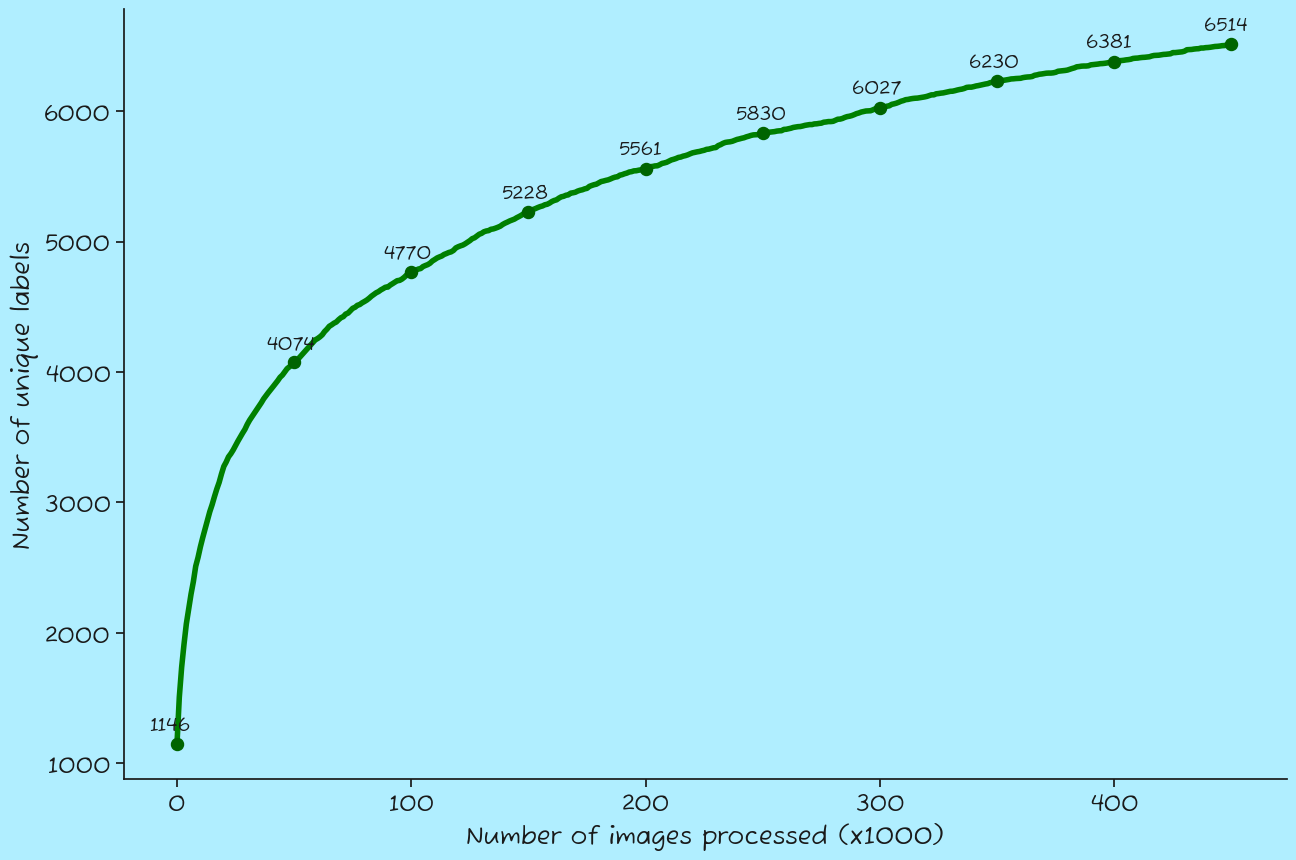

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#plt.rcParams.update({"font.size": 14})

sns.set(
    font="Fuzzy Bubbles",
    font_scale=1.5,
    rc={
        "lines.linewidth": 4,
        "font.size": 14,
        "axes.axisbelow": False,
        "axes.edgecolor": "k",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "k",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "#B0EEFF",  # Using face_color here doesn't work for some reason
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "k",
        "xtick.bottom": True,
        "xtick.color": "k",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "k",
        "ytick.direction": "out",
        "ytick.left": True,
        "ytick.right": False,
    },
)

# Open the unique_label_count_trend.csv file and plot the data
df = pd.read_csv("unique_label_count_trend.csv", header=None)
df.columns = ["total_unique_labels"]
df.plot(y="total_unique_labels", figsize=(15, 10), color="green", legend=False)
plt.xlabel("Number of images processed (x1000)")
plt.ylabel("Number of unique labels")
y_values = df.iloc[::50, :]["total_unique_labels"]
plt.scatter(range(0, len(df), 50), y_values, marker='o', color='darkgreen', zorder=3, s=75)
# Annotate the graph with the y value for every 50 x values
for i in range(0, len(df), 50):
    plt.annotate(df.iloc[i]["total_unique_labels"], (i, df.iloc[i]["total_unique_labels"]), textcoords="offset points", xytext=(-20, 10))
# Save the plot as svg
plt.savefig("unique_label_count_trend.svg", format="svg")
plt.savefig("unique_label_count_trend.jpg", format="jpg")
plt.show()


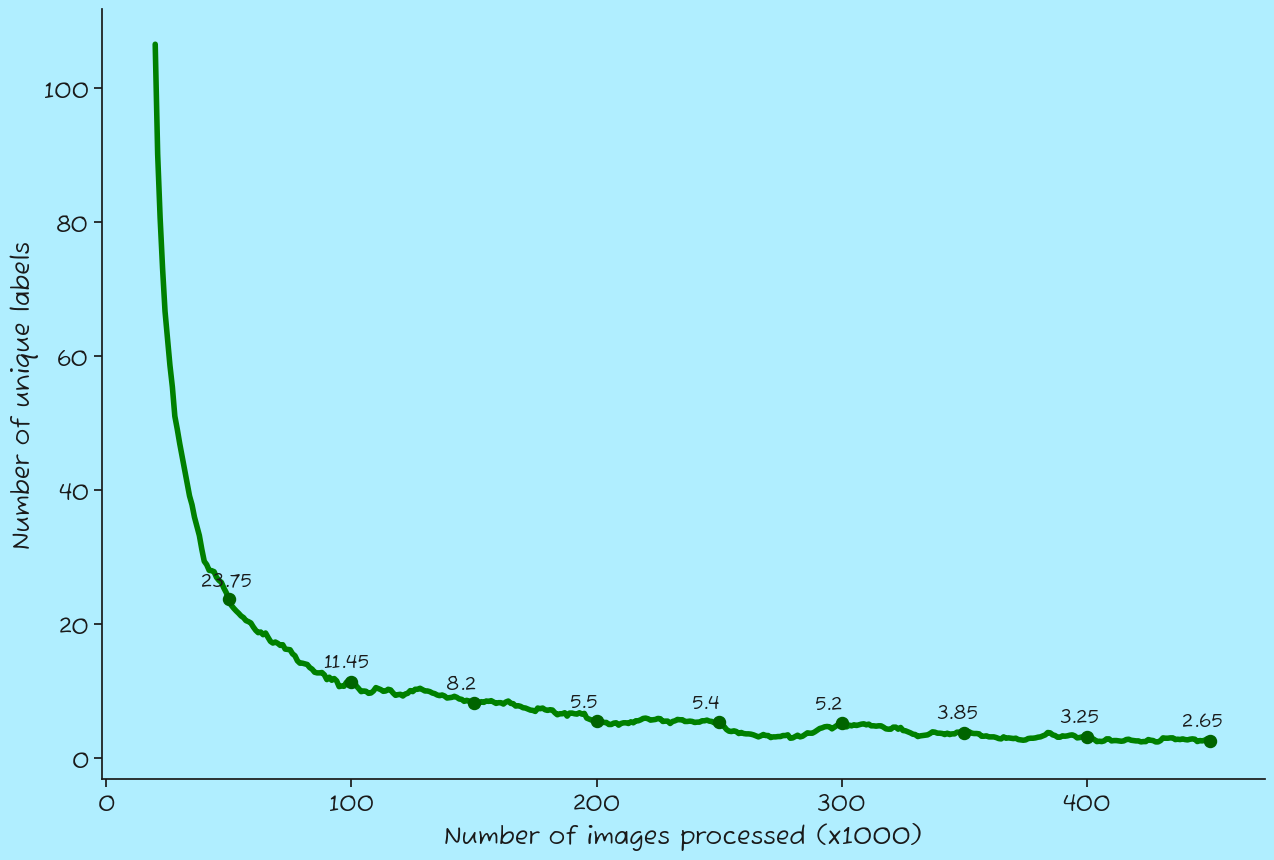

<Figure size 640x480 with 0 Axes>

In [8]:

# Plot the delta between each y value and the previous y value
df["delta"] = df["total_unique_labels"].diff()
df["delta"] = df["delta"].rolling(20).mean()
df.plot(y="delta", figsize=(15, 10), color="green", legend=False)
plt.xlabel("Number of images processed (x1000)")
plt.ylabel("Number of unique labels")
y_values = df.iloc[::50, :]["delta"]
plt.scatter(range(0, len(df), 50), y_values, marker='o', color='darkgreen', zorder=3, s=75)
# Annotate the graph with the y value for every 50 x values
for i in range(0, len(df), 50):
    plt.annotate(df.iloc[i]["delta"], (i, df.iloc[i]["delta"]), textcoords="offset points", xytext=(-20, 10))
plt.show()
# Save the plot as svg
plt.savefig("unique_label_count_delta.svg", format="svg")
